# <p align="center">**Pré-Processamento e Vetorização** 🧬</p>
 
##### <p align="center">**Autores:**  Glauber Nascimento & Lorena Ribeiro</p>
##### <p align="center">**Orientador:**  James Moraes de Almeida  </p>
 

<div style="background-color: lightblue; font-size: 18px; padding: 10px;">
<div style="text-align: justify"><strong>Objetivo:</strong> Classificar imagens de folhas de plantas em saudáveis e doentes, e diferenciar suas patologias a partir de Processamento de Imagens utilizando CNN.</div>

## 📚Importando bibliotecas 

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

plt.style.use('classic')

import optuna                  #bibliotecas para otimização
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential


from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop

## ⚖️Verificando o balanceamento das imagens

In [32]:
base_dir = "plant-disease-recognition-dataset/Train/Train"

train_healthy = []
train_powd = []
train_rusty = []

for classe in os.listdir(base_dir):
    caminho = os.path.join(base_dir, classe)
    if os.path.isdir(caminho):
        n_imagens = len(os.listdir(caminho))

        if classe == 'Healthy':
            train_healthy.append(n_imagens)
        elif classe == 'Powdery':
            train_powd.append(n_imagens)
        else:
            train_rusty.append(n_imagens)
        
        print(f"{classe}: {n_imagens} imagens")


Healthy: 458 imagens
Powdery: 430 imagens
Rust: 434 imagens


In [33]:
base_dir = "plant-disease-recognition-dataset/Validation/Validation"

val_healthy = []
val_powd = []
val_rusty = []

for classe in os.listdir(base_dir):
    caminho = os.path.join(base_dir, classe)
    if os.path.isdir(caminho):
        n_imagens = len(os.listdir(caminho))

        if classe == 'Healthy':
            val_healthy.append(n_imagens)
        elif classe == 'Powdery':
            val_powd.append(n_imagens)
        else:
            val_rusty.append(n_imagens)
        
        print(f"{classe}: {n_imagens} imagens")


Healthy: 20 imagens
Powdery: 20 imagens
Rust: 20 imagens


In [34]:
base_dir = "plant-disease-recognition-dataset/Test/Test"

test_healthy = []
test_powd = []
test_rusty = []

for classe in os.listdir(base_dir):
    caminho = os.path.join(base_dir, classe)
    if os.path.isdir(caminho):
        n_imagens = len(os.listdir(caminho))

        if classe == 'Healthy':
        
            test_healthy.append(n_imagens)
        elif classe == 'Powdery':
        
            test_powd.append(n_imagens)
        else:
        
            test_rusty.append(n_imagens)
        
        print(f"{classe}: {n_imagens} imagens")

Healthy: 50 imagens
Powdery: 50 imagens
Rust: 50 imagens


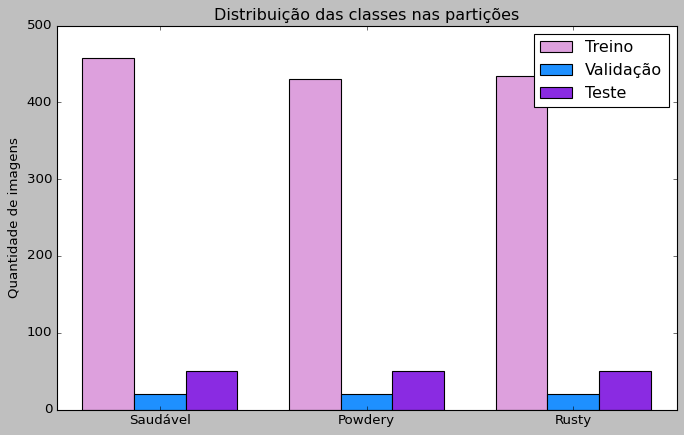

In [35]:
plt.figure(figsize=(10, 6))

labels = ['Saudável', 'Powdery', 'Rusty']

test  = [int(test_healthy[0]),  int(test_powd[0]),  int(test_rusty[0])]
val   = [int(val_healthy[0]),   int(val_powd[0]),   int(val_rusty[0])]
train = [int(train_healthy[0]), int(train_powd[0]), int(train_rusty[0])]

x = np.arange(len(labels))  # posições básicas: 0,1,2
width = 0.25                # largura de cada barra

plt.bar(x - width, train, width, label='Treino', color='plum')
plt.bar(x, val, width, label='Validação', color='dodgerblue')
plt.bar(x + width, test,  width, label='Teste', color='blueviolet')

plt.xticks(x, labels)
plt.title("Distribuição das classes nas partições")
plt.ylabel("Quantidade de imagens")
plt.legend()
plt.show()


## 🗂️Carregamento do dataset

In [36]:
'''Exemplo com Cifar10 para o carregamento'''

# (X_train, y_train), (X_test, y_test) = cifar10.load_data()
# print("The size of training dataset X is: ", X_train.shape)
# print("The size of testing dataset X is: ", X_test.shape)

# print("The size of training dataset y is: ", y_train.shape)
# print("The size of testing dataset y is: ", y_test.shape)

'Exemplo com Cifar10 para o carregamento'

In [37]:
"""Verificando o tamanho da imagem"""
from PIL import Image

base_dir = "plant-disease-recognition-dataset/Train/Train"
tamanhos = set()

for classe in os.listdir(base_dir):
    pasta_classe = os.path.join(base_dir, classe)
    if os.path.isdir(pasta_classe):
        for arquivo in os.listdir(pasta_classe):
            caminho = os.path.join(pasta_classe, arquivo)
            img = Image.open(caminho)
            tamanhos.add(img.size)

print("Tamanhos encontrados:", tamanhos)


Tamanhos encontrados: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (4608, 3456), (2421, 2279)}


Visto que nossas imagens tem alta resolução, conforme os tamanhos encontrados no dataset, poderiamos seguir por duas vertentes: 224x224 ou 128z128. A primeira preserva mais os detalhes, todavia é mais interessante para modelos com pesos pré-treinados, que não é o caso do nosso projeto. Sendo assim, será utilizado o tamanho 128x128, visto que tem menor custo computacional e não precisa de um pré-treinamento, tentando superar as barreriras devido a perda de detalhes finos 

In [38]:
import tensorflow as tf

# Caminhos das pastas do dataset
train_dir = "plant-disease-recognition-dataset/Train/Train"
val_dir   = "plant-disease-recognition-dataset/Validation/Validation"
test_dir  = "plant-disease-recognition-dataset/Test/Test"

# Parâmetros (ajuste do tamanho da imagem)
img_size = (128, 128)   
batch_size = 32

# Carregar os datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="int",        # igual ao CIFAR, produz y no formato inteiro
    seed=710,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="int",
    seed=7200,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    seed=710,
    image_size=img_size,
    batch_size=batch_size
)

# Mostrar classes detectadas
class_names = train_ds.class_names
print("Classes detectadas:", class_names)

# "X" e "y" equivalentes
X_train, y_train = [], []
for batch_x, batch_y in train_ds:
    X_train.append(batch_x)
    y_train.append(batch_y)

X_test, y_test = [], []
for batch_x, batch_y in test_ds:
    X_test.append(batch_x)
    y_test.append(batch_y)

# Converter listas para tensores grandes (opcional)
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)
X_test  = tf.concat(X_test, axis=0)
y_test  = tf.concat(y_test, axis=0)

print("The size of training dataset X is:", X_train.shape)
print("The size of testing dataset X is:", X_test.shape)

print("The size of training dataset y is:", y_train.shape)
print("The size of testing dataset y is:", y_test.shape)


Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Classes detectadas: ['Healthy', 'Powdery', 'Rust']
The size of training dataset X is: (1322, 128, 128, 3)
The size of testing dataset X is: (150, 128, 128, 3)
The size of training dataset y is: (1322,)
The size of testing dataset y is: (150,)


In [39]:
X_train = X_train.numpy()
X_test = X_test.numpy()


In [40]:
X_train = (X_train.astype('float32')) / 255.
X_test = (X_test.astype('float32')) / 255.


## 📈Otimizando hiperparâmetros

In [41]:

def objective(trial):

    # Definindo os hiperparâmetros
    kernel_initializer = trial.suggest_categorical(
        "kernel_initializer", ["he_uniform", "random_uniform"]
    )

    activation = trial.suggest_categorical(
        "activation", ["relu", "tanh"]
    )

    dropout_rate = trial.suggest_float(
        "dropout", 0.1, 0.5
    )

    lr = trial.suggest_float(
        "lr", 1e-4, 1e-2, log=True
    )

    # Número de filtros
    filters1 = trial.suggest_categorical("filters1", [16, 32, 64])    #1 convolução
    filters2 = trial.suggest_categorical("filters2", [32, 64, 128])    #2 convolução

   # Modelo  
    model = Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)), 

        Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),

        Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(256, activation=activation, kernel_initializer=kernel_initializer),
        Dropout(dropout_rate),

        Dense(3, activation='softmax')
    ])

    optimizer = SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Treino
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,             # Poucas épocas, apenas para otimizar
        verbose=0
    )

    # queremos maximizar VAL_ACCURACY
    val_acc = history.history["val_accuracy"][-1]

    return val_acc


In [42]:
# from optuna import create_study

# NOME_DO_ESTUDO = "arvore_aleatoria_pinguins"  #optuna vai salvar dessa forma no computador

# objeto_de_estudo = create_study(
#     direction="minimize",
#     study_name=NOME_DO_ESTUDO,
#     storage=f"sqlite:///{NOME_DO_ESTUDO}.db",  #carrega os dados, não perde o trabalhoe
#     load_if_exists=True,
# )

In [43]:
study = optuna.create_study(
    direction="maximize",
    study_name="teste_optuna",
    storage="sqlite:///cnn_optuna.db",
    load_if_exists=True
)

study.optimize(objective, n_trials=50)


[I 2025-11-15 17:14:16,000] Using an existing study with name 'teste_optuna' instead of creating a new one.


c:\Users\lorena24014\.conda\envs\img_proc\lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-11-15 17:21:32,391] Trial 2 finished with value: 0.3333333432674408 and parameters: {'kernel_initializer': 'he_uniform', 'activation': 'tanh', 'dropout': 0.48363995195952614, 'lr': 0.002712659835293657, 'filters1': 64, 'filters2': 64}. Best is trial 0 with value: 0.5333333611488342.
[I 2025-11-15 17:25:18,402] Trial 3 finished with value: 0.5666666626930237 and parameters: {'kernel_initializer': 'he_uniform', 'activation': 'relu', 'dropout': 0.2809375140564572, 'lr': 0.0002578298946444275, 'filters1': 32, 'filters2': 64}. Best is trial 3 with value: 0.5666666626930237.
[I 2025-11-15 17:33:55,893] Trial 4 finished with value: 0.5 and parameters: {'kernel_initiali

KeyboardInterrupt: 

In [ ]:
print("Melhores parâmetros:")
for k, v in study.best_params.items():
    print(k, ":", v)

print("Melhor accuracy:", study.best_value)


## ⛏️Construindo a CNN

In [ ]:
# num_classes = 3
# kernel_initializer = 'he_uniform'    #Also try 'zeros', 'random_uniform', 'he_uniform', 'glorot_uniform'
# drop = 0.25

# model1 = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)),    #normalização para float de forma diferente por serem tensores

#     Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),  # 1arg: número de filtros; 2 arg: tamanho da janela (menor para mais detalhes);
#     Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),
#     MaxPooling2D((2,2)),
#     Dropout(drop),

#     Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),
#     Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),
#     MaxPooling2D((2,2)),
#     Dropout(drop),

#     Flatten(),
#     Dense(512, activation='relu', kernel_initializer=kernel_initializer),
#     Dropout(drop),
#     Dense(num_classes, activation='softmax')  # 3 classes
# ])

# opt = SGD(learning_rate=0.001, momentum=0.9)

# model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model1.summary()


c:\Users\lorena24014\.conda\envs\img_proc\lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,622,051 (128.26 MB)

 Trainable params: 33,622,051 (128.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3336 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3434 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 942ms/step - accuracy: 0.3533 - loss: 1.0979 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3487 - loss: 1.0981 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3449 - loss: 1.0981 - val_accuracy: 0.3333 - val_loss: 1.0983
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3487 - loss: 1.0974 - val_accuracy: 0.3333 - val_loss: 1.0982
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 972ms/step - accuracy: 0.3457 - loss: 1.0971 - val_accuracy: 0.3333 - val_loss: 1.0978
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3593 - loss: 1.0970 - val_accuracy: 0.3333 - val

In [ ]:
# _, acc = model1.evaluate(X_test, y_test)
# print("Accuracy = ", (acc * 100.0), "%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3533 - loss: 1.1143
Accuracy =  35.33333241939545 %
